# Predicting the Long Term Daily Ridership at Specific Locations
- Use the best data split date from the previous notebook for long term prediction
- Look at how well the best regressor predicts daily ridership at specific bike stations

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

In [2]:
# Scoring function for a regressor
def score_regressor(regressor, X, y, X_train=None, y_train=None):
    
    result = {}
    
    y_pred = regressor.predict(X)
    
    # calculate R^2 and MSE
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    scores = {'r2_score': r2,
                     'mse': mse}
    
    result['scores'] = scores
    
    # If train option is on, return results for the training set too
    if (X_train is not None) & (y_train is not None):
        
        y_pred_train = regressor.predict(X_train)
        
        r2_train = r2_score(y_train, y_pred_train)
        mse_train = mean_squared_error(y_train, y_pred_train)

        scores_train = {'r2_score': r2_train,
                                    'mse': mse_train}
        
        result['scores_train'] = scores_train
    
    # If the regressor has feature importances attribute, include in the result
    try:
        result['feature_importances'] = regressor.feature_importances_
    except:
        pass
    
    return result

# A method to print out the regression scores
def print_regressor_scores(result, trainset=False, feature_labels=None):
    
    print('==== Regressor Performance ====')
    if trainset:
        print('Train: R2 = %f, mse = %f'  % (result['scores_train']['r2_score'], result['scores_train']['mse']))
    print('Test: R^2 = %f, mse = %f'  % (result['scores']['r2_score'], result['scores']['mse']))
    
    if (feature_labels is not None):
        importances = result['feature_importances']
        indices = np.argsort(importances)[::-1]
        print('--------------- Feature Importances ---------------')
        for f in range(len(feature_labels)):
            print('%2d) %-*s %f' % (f + 1, 20, feature_labels[indices[f]], importances[indices[f]]))
        print('\n')
        
    return

# Importing the subscriber data

In [3]:
# Import subscriber data and remove entries with NaN
data = pd.read_csv('../data/for_predictions/daily_p_s_pred_basic.csv')
data = data.dropna()

In [4]:
# Remove entries that have negative wind strength
data = data[data['AWND'] >= 0]

In [5]:
# Create date field and convert it to datetime object
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str) + '-' + data['day'].astype(str) 
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [6]:
# Check the columns
data.columns

Index(['year', 'month', 'day', 'dayofweek', 'st_latitude', 'st_longitude',
       'closest_college_distance', 'closest_subway_distance',
       'closest_theater_distance', 'closest_museum_distance',
       'closest_park_distance', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND',
       'pickups', 'date'],
      dtype='object')

In [7]:
# Reorder the columns and  preview the data
data = data[['date', 'year', 'month', 'day', 'dayofweek', 'st_latitude', 'st_longitude',
       'closest_college_distance', 'closest_subway_distance',
       'closest_theater_distance', 'closest_museum_distance',
       'closest_park_distance', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND',
       'pickups']]
data.head()

,date,year,month,day,dayofweek,st_latitude,st_longitude,closest_college_distance,closest_subway_distance,closest_theater_distance,closest_museum_distance,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,pickups
0,2013-07-01,2013,7,1,0,40.767272,-73.993929,0.449863,0.836766,0.509623,0.648424,0.190527,21.3,0.0,0.0,25.0,22.2,1.4,47
1,2013-07-01,2013,7,1,0,40.719116,-74.006667,0.438224,0.012754,0.179887,0.470931,0.154135,21.3,0.0,0.0,25.0,22.2,1.4,73
2,2013-07-01,2013,7,1,0,40.711174,-74.000165,0.390559,0.372382,0.416180,0.590027,0.143915,21.3,0.0,0.0,25.0,22.2,1.4,13
3,2013-07-01,2013,7,1,0,40.683826,-73.976323,0.970719,0.176488,3.503029,0.224781,0.108015,21.3,0.0,0.0,25.0,22.2,1.4,19
4,2013-07-01,2013,7,1,0,40.741776,-74.001497,0.717327,0.062889,0.234855,0.368229,0.170808,21.3,0.0,0.0,25.0,22.2,1.4,47


In [8]:
# Check basic stats of the data
data.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).round(3)

,year,month,day,dayofweek,st_latitude,st_longitude,closest_college_distance,closest_subway_distance,closest_theater_distance,closest_museum_distance,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,pickups
count,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000
mean,2015.075,6.681,15.700,2.982,40.727,-73.983,0.672,0.284,1.211,0.694,0.151,2.983,2.013,14.315,17.109,9.128,2.402,63.516
std,1.166,3.599,8.832,2.000,0.028,0.018,0.431,0.238,1.343,0.658,0.027,8.225,15.293,57.784,10.284,9.538,1.048,62.068
min,2013.000,1.000,1.000,0.000,40.518,-74.031,0.022,0.003,0.011,0.019,0.088,0.000,0.000,0.000,-9.300,-18.200,0.300,1.000
25%,2014.000,3.000,8.000,1.000,40.705,-73.996,0.338,0.100,0.278,0.280,0.129,0.000,0.000,0.000,8.300,2.200,1.700,18.000
50%,2015.000,7.000,16.000,3.000,40.725,-73.984,0.604,0.224,0.556,0.505,0.153,0.000,0.000,0.000,17.800,8.900,2.200,44.000
75%,2016.000,10.000,23.000,5.000,40.749,-73.971,0.911,0.414,2.008,0.797,0.171,1.000,0.000,0.000,26.700,17.800,3.000,90.000
95%,2017.000,12.000,30.000,6.000,40.773,-73.948,1.447,0.774,4.081,2.275,0.189,18.300,0.000,130.000,31.700,22.800,4.400,184.000
99%,2017.000,12.000,31.000,6.000,40.790,-73.940,1.895,1.006,5.125,3.199,0.204,40.100,76.000,300.000,34.400,25.600,5.500,277.000
max,2017.000,12.000,31.000,6.000,40.804,-73.930,11.939,7.748,21.617,7.715,0.218,126.200,279.000,480.000,36.700,28.300,8.200,827.000


<b>Get location information for 3 subscriber stations</b>

In [9]:
stations_info = pd.read_csv('../data/processed/stations_info_complete.csv')

In [10]:
stations_info.head()

,st_id,st_name,st_latitude,st_longitude
0,72,W 52 St & 11 Ave,40.767272,-73.993929
1,79,Franklin St & W Broadway,40.719116,-74.006667
2,82,St James Pl & Pearl St,40.711174,-74.000165
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
4,116,W 17 St & 8 Ave,40.741776,-74.001497


In [11]:
# Split the data
split_date = dt.date(2016, 7, 16)
past = data[data['date'] <= split_date]
future = data[data['date'] > split_date]

In [12]:
# Set up Xs and ys
X_past = past[past.columns[1:-1]]
X_future = future[future.columns[1:-1]]
y_past = past[past.columns[-1]]
y_future = future[future.columns[-1]]

X_past = np.array(X_past).reshape(X_past.shape)
X_future = np.array(X_future).reshape(X_future.shape)
y_past = np.array(y_past).reshape(-1, 1).ravel()
y_future = np.array(y_future).reshape(-1, 1).ravel()

In [13]:
%%time
# Train RandomForestRegressor
regressor = RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=4)
regressor.fit(X_past, y_past)

CPU times: user 2min 12s, sys: 1.34 s, total: 2min 13s
Wall time: 34.9 s


In [35]:
# Set up a function to plot prediction results using station ID
def plot_regression_station(st_id, past, future, regressor, name=None, figsize=(16, 16)):
    
    # Get latitude and longitude
    location = stations_info[stations_info.st_id == st_id]
    location_lat = float(location.st_latitude.unique())
    location_long = float(location.st_longitude.unique())
    
    # Set up Xs and ys for location specific data
    location_past = past[(past['st_latitude'] == location_lat) & (past['st_longitude'] == location_long)]
    location_future = future[(future['st_latitude'] == location_lat) & (future['st_longitude'] == location_long)]
    
    # Create dates vectors
    past_dates = np.array(location_past[location_past.columns[0]]).reshape(-1, 1)
    future_dates = np.array(location_future[location_future.columns[0]]).reshape(-1, 1)
    
    # Set up Xs and ys for the location
    X_past_location = location_past[location_past.columns[1:-1]]
    X_future_location = location_future[location_future.columns[1:-1]]
    y_past_plocation = location_past[location_past.columns[-1]]
    y_future_location = location_future[location_future.columns[-1]]

    X_past_location = np.array(X_past_location).reshape(X_past_location.shape)
    X_future_location = np.array(X_future_location).reshape(X_future_location.shape)
    y_past_plocation = np.array(y_past_plocation).reshape(-1, 1).ravel()
    y_future_location = np.array(y_future_location).reshape(-1, 1).ravel()
    
    # Make predictions for the past and future
    location_past_predict = regressor.predict(X_past_location)
    location_future_predict = regressor.predict(X_future_location)
    
    # Plot results. 1st plot plots all data, 2nd one only future
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    ax1.plot(past_dates, y_past_plocation, 
                  ls='-', lw=0.5,
                  label='Past, Actual')
    ax1.plot(past_dates, location_past_predict, 
                  ls='-',  lw=0.5,
                  label='Past, Predicted')
    ax1.plot(future_dates, y_future_location, 
                  ls='-', lw=0.5, c='b', alpha=0.6,
                  label='Future, Actual')
    ax1.plot(future_dates, location_future_predict, 
                  ls='-',  lw=0.5, c='r', alpha=0.6,
                  label='Future, Predicted')
    ax1.set_title('Ridership Prediction At %s' % name, fontsize=16)
    ax1.set_xlabel('Dates', fontsize=15)
    ax1.set_ylabel('Daily Ridership', fontsize=14)
    ax1.legend(loc='upper left', fontsize=12)
    
    ax2.plot(future_dates, y_future_location, 
                  ls='-', lw=1, c='b', alpha=0.6,
                  label='Future, Actual')
    ax2.plot(future_dates, location_future_predict, 
                  ls='-',  lw=1, c='r', alpha=0.6,
                  label='Future, Predicted')
    ax2.set_title('Ridership Prediction At %s' % name, fontsize=16)
    ax2.set_xlabel('Dates', fontsize=15)
    ax2.set_ylabel('Daily Ridership', fontsize=14)
    ax2.legend(loc='upper left', fontsize=12)
    
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(12)
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(12)
    
    for tick in ax1.get_yticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(12)
    for tick in ax2.get_yticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(12)
        
    plt.tight_layout()

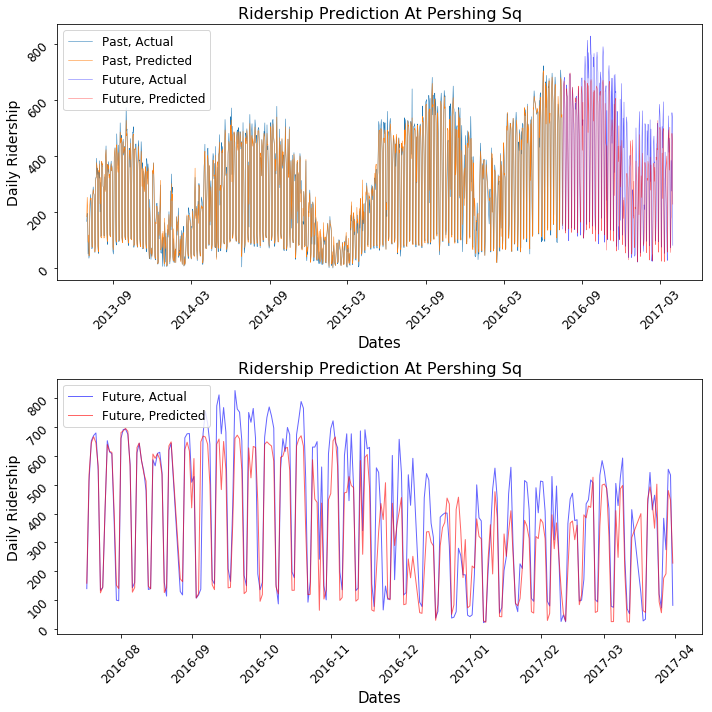

In [36]:
# Ridership prediction at Pershing Sq
plot_regression_station(519, past, future, regressor, name='Pershing Sq', figsize=(10, 10))

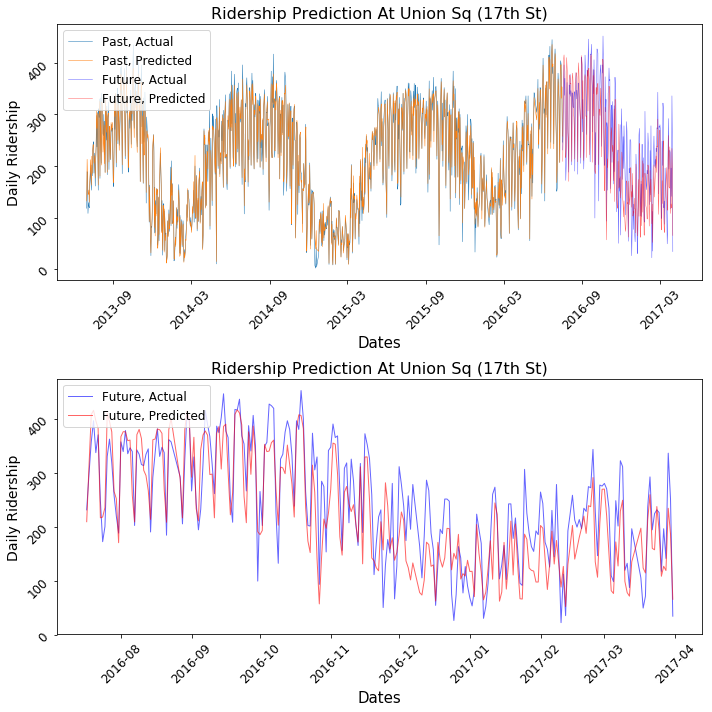

In [37]:
# Ridership prediction at Union Sq
plot_regression_station(497, past, future, regressor, name='Union Sq (17th St)', figsize=(10, 10))

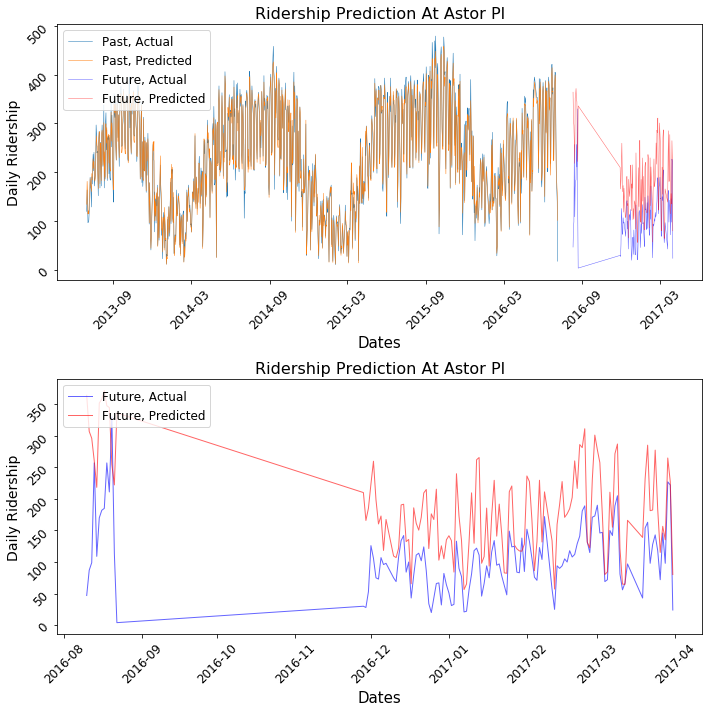

In [38]:
# Astor Pl
plot_regression_station(293, past, future, regressor, name='Astor Pl', figsize=(10, 10))

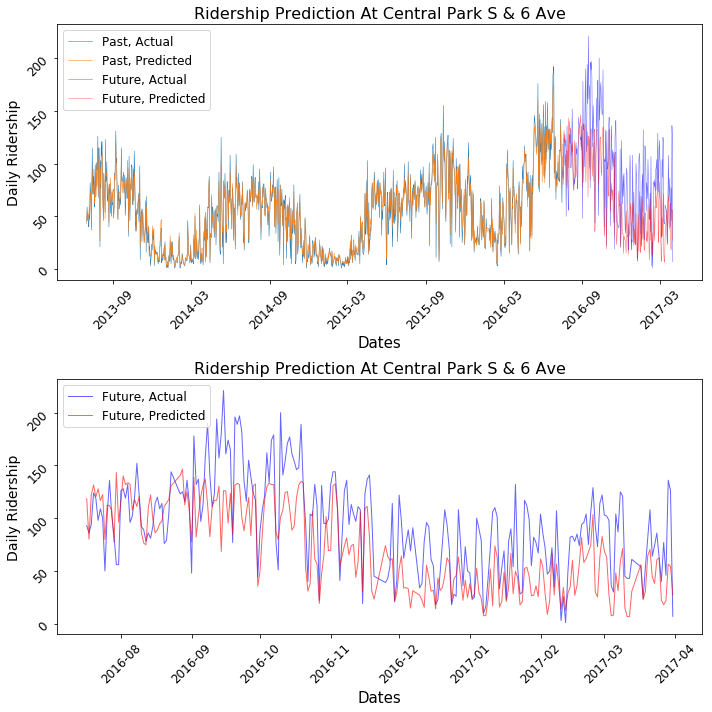

In [39]:
# Near Central Park
plot_regression_station(2006, past, future, regressor, name='Central Park S & 6 Ave', figsize=(10, 10))

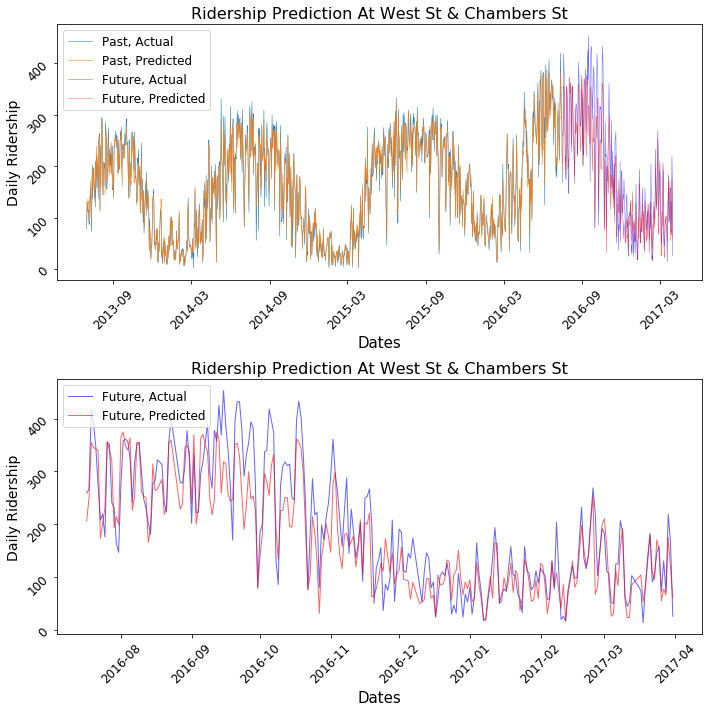

In [40]:
# West Side
plot_regression_station(426, past, future, regressor, name='West St & Chambers St', figsize=(10, 10))